# Self-Driving Car Engineer Nanodegree

## Project: **Finding Lane Lines on the Road** 

The goals of this project are:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimations of lane curvature and vehicle position.

## General setup
---

### Import dependencies

In [1]:
import numpy as np
import time
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

### Get image lists

In [2]:
# List of calibration images
calibration_images = glob.glob('camera_cal/calibration*.jpg')
n_calib_imgs = len(calibration_images)
print(str(n_calib_imgs) + ' detected images for calibration: ' + str(calibration_images))
print('')

test_images = glob.glob('test_images/*.jpg')
n_test_imgs = len(test_images)
print(str(n_test_imgs) + ' detected images for testing: ' + str(test_images))

20 detected images for calibration: ['camera_cal/calibration9.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration1.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration2.jpg']

8 detected images for testing: ['test_images/straight_lines1.jpg', 'test_images/test2.jpg', 'test_images/straight_lines2.jpg', 'test_images/test4.jpg', 'test_images/test1.jpg', 'test_images/test6.jpg', 'test_images/test5.jpg', 'test_images/test3.jpg']


## Camera calibration
---
### General setup

In [3]:
# Amount of inner corners in each axis
nx = 9
ny = 6

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

### Get image points, calibrate camera and show a sample undistortion

Camera matrix:
[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

Distortion coefficients:
[[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259866]]


Text(0.5,1,'Undistorted image')

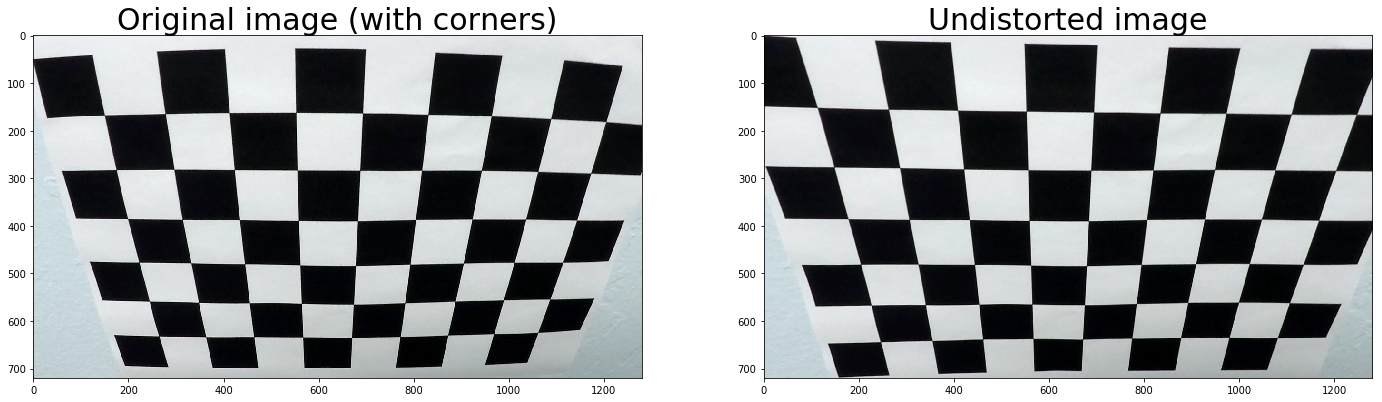

In [4]:
# Step through the list and search for chessboard corners
for fname in calibration_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Get camera matrix (mtx) and distortion coefficients (dist)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print('Camera matrix:')
print(mtx)
print('')
print('Distortion coefficients:')
print(dist)

# Display a sample undistortion with the last calibration image
# Read last image
img = cv2.imread(calibration_images[n_calib_imgs-1])

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Divide plot and show a sample result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) 
ax1.imshow(img)
ax1.set_title('Original image (with corners)', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted image', fontsize=30)

## Undistort test images
---

Text(0.5,1,'Undistorted')

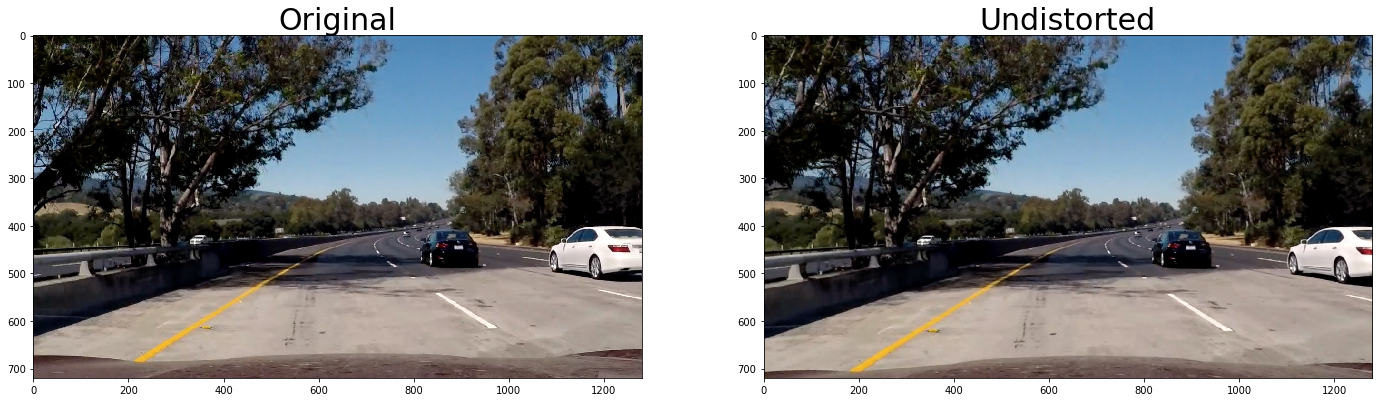

In [5]:
# Empty list to store the undistorted test images later on
undist_test_imgs = []

# Step through the test list,undistort images and store them
for fname in test_images:
    # Read current image
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Append to list of undistorted test images
    undist_test_imgs.append(undist)
    
# Divide plot and show a sample result
original = cv2.imread(test_images[n_test_imgs-2])
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
processed = undist_test_imgs[n_test_imgs-2]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) 
ax1.imshow(original)
ax1.set_title('Original', fontsize=30)
ax2.imshow(processed)
ax2.set_title('Undistorted', fontsize=30)

## Combine color and gradient filtering to get binary mask
---

### Sobel auxiliar functions

In [6]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """ 
    Applies Sobel x or y, then takes an absolute value and applies a threshold.
    """

    # Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel)

    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Create a mask of 1's where the scaled gradient magnitude
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1

    return grad_binary


def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    """ 
    Applies Sobel x and y, then computes the magnitude of the gradient
    and applies a threshold
    """

    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale = np.max(mag)/255
    scaled_mag = (mag/scale).astype(np.uint8)

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag > mag_thresh[0]) & (scaled_mag < mag_thresh[1])] = 1

    return binary_output


def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Applies Sobel x and y, then computes the direction of the gradient
    and applies a threshold.
    """

    # Gradients in x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Absolute values of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # Calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)

    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1

    return binary_output


### Apply color and gradient thresholding

Text(0.5,1,'Double-thresholded B&W')

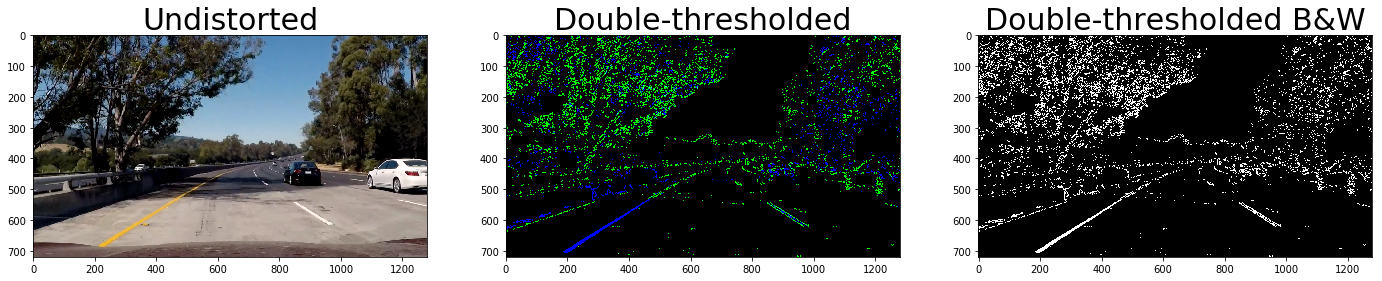

In [7]:
# Empty list to store the filtered binary images
binary_imgs = []
binary_imgs_bw = [] # Same but images will be in black and white

# Setup hyperparameters
s_thresh = (170, 255) #Threshold for the S channel from HLS
sx_thresh = (20, 100) #Sobel X threshold
sy_thresh = (20, 100) #Sobel Y thresh
sm_thresh = (30, 100) #Sobel magnitude thresh
sd_thresh = (0.7, 1.3) #Sobel direction thresh

# Step through the undistorted test images and use color and gradient to filter them
for img in undist_test_imgs:
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0] # Color channel
    l_channel = hls[:,:,1] # Lightness/grayscale channel
    s_channel = hls[:,:,2] # Saturation channel

    #Apply Sobels
    gradx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=3, thresh=sx_thresh)
    grady = abs_sobel_thresh(l_channel, orient='y', sobel_kernel=3, thresh=sy_thresh)
    mag_binary = mag_thresh(l_channel, sobel_kernel=3, mag_thresh=sm_thresh)
    dir_binary = dir_threshold(l_channel, sobel_kernel=15, thresh=sd_thresh)
    
    #Combine Sobel's binary outputs
    sobel_combined = np.zeros_like(dir_binary)
    sobel_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel < s_thresh[1])] = 1 

    # Stack each channel and append to the list
    sobel_and_s_binary=np.dstack((np.zeros_like(s_channel), sobel_combined, s_binary))
    binary_imgs.append(sobel_and_s_binary)
    
    # Create black and white version
    binary_bw = (sobel_combined == 1) | (s_binary == 1)
    binary_imgs_bw.append(binary_bw)

# Divide plot and show a sample result
original = cv2.imread(test_images[n_test_imgs-2])
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
processed = binary_imgs[n_test_imgs-2]
processed_bw = binary_imgs_bw[n_test_imgs-2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9)) 
ax1.imshow(original)
ax1.set_title('Undistorted', fontsize=30)
ax2.imshow(processed)
ax2.set_title('Double-thresholded', fontsize=30)
ax3.imshow(processed_bw, cmap='gray')
ax3.set_title('Double-thresholded B&W', fontsize=30)

## Transform double-thresholded images
---

Text(0.5,1,'Warped')

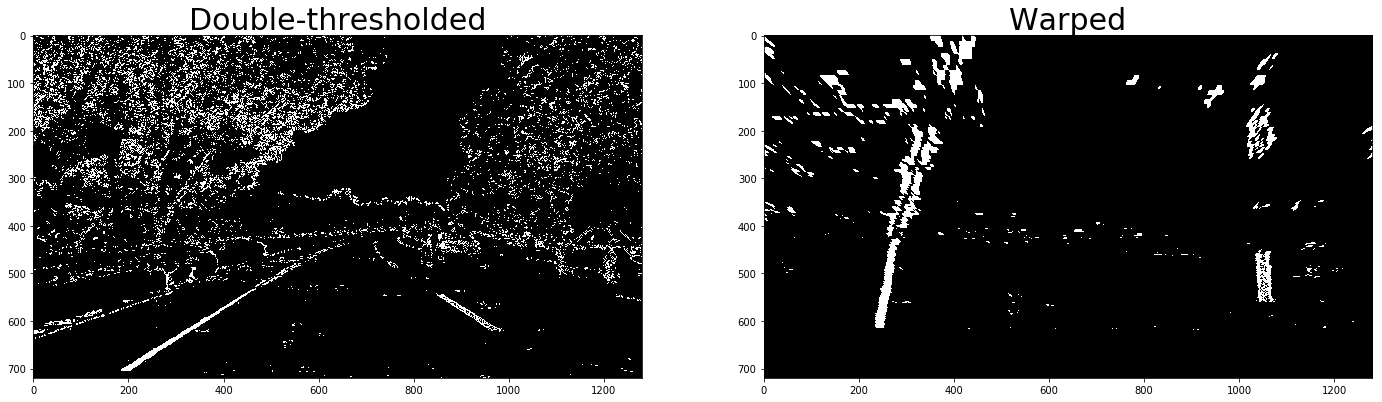

In [8]:
# Create a list to contain the transformed images (top-down views)
warped_imgs = []
    
# Transformation matrices
M = None
M_inv = None

# Step through the double-thresholded images and transform them
for img in binary_imgs_bw:
    #Get imamge dimensions
    ysize = img.shape[0]
    xsize = img.shape[1]

    # Set the source reference points for the transformation
    src_1 = [0, ysize]
    src_2 = [int(0.4*xsize), int(0.65*ysize)]
    src_3 = [int(0.6*xsize), int(0.65*ysize)]
    src_4 = [xsize, ysize]

    src = np.float32([src_1, src_2, src_3, src_4])

    # Set the destination reference points (image reduced 100 pixels)
    xsize2 = xsize-100
    ysize2 = ysize-100
    
    dst_1 = [100, ysize2]
    dst_2 = [100, 100]
    dst_3 = [xsize2, 100]
    dst_4 = [xsize2, ysize2]

    dst = np.float32([dst_1, dst_2, dst_3, dst_4])

    # Compute transformation matrix and the one to perform the oposite transformation
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image and append to the list of warped/transformed images
    warped_img = cv2.warpPerspective(img.astype(np.uint8), M, (xsize, ysize), flags=cv2.INTER_LINEAR)
    warped_imgs.append(warped_img)

# Divide plot and show a sample result
original = binary_imgs_bw[n_test_imgs-2]
processed = warped_imgs[n_test_imgs-2]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(original, cmap='gray')
ax1.set_title('Double-thresholded', fontsize=30)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Warped', fontsize=30)

## Detect lane pixels and fit a polynomial
---
### Auxiliar functions definition

In [9]:
def find_lane_pixels(binary_warped, nwindows, margin, minpix):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peaks of the left and right halves of the histogram (starts of lane lines)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)

        ### Identify the nonzero pixels in x and y within the window ###
        # Crop current window
        nonzero_left = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)
        nonzero_right = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)
        # Get nonzero indices
        good_left_inds = nonzero_left.nonzero()[0]
        good_right_inds = nonzero_right.nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If good_inds > minpix pixels are, recenter next window on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.array(nonzerox[good_left_inds]).mean())
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.array(nonzerox[good_right_inds]).mean())
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, nwindows=9, margin=100, minpix=50):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, nwindows, margin, minpix)

    ### Fit a second order polynomial to each ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fit, right_fit

### Get lane lines with sliding window, fit a polynomial, and show sample results

Text(0.5,1,'Sliding windows')

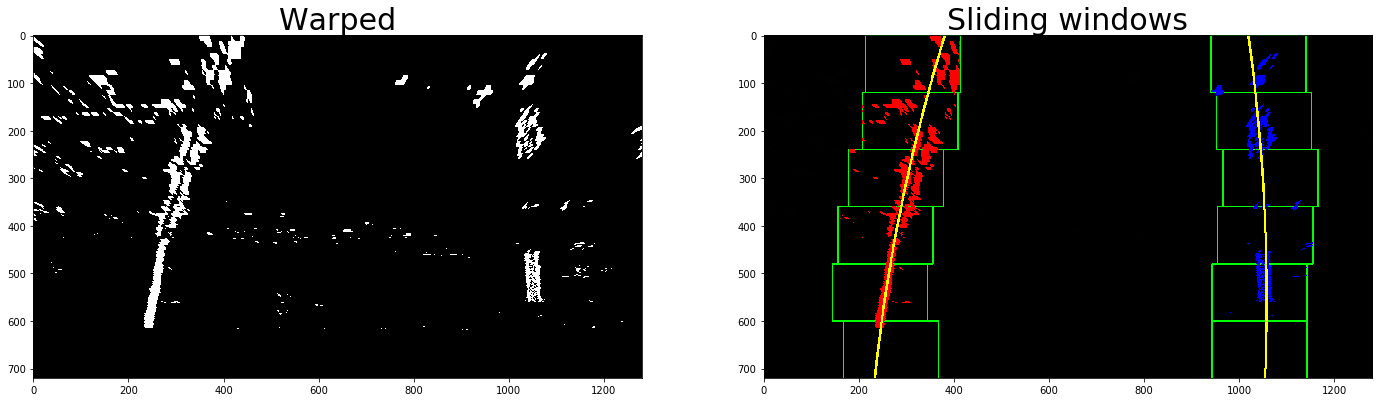

In [10]:
# List to store warped images with the windows and polynomials drawn in them
poly_imgs = []
left_fit_list = []
right_fit_list = []

# Set hyperparameters for the sliding window search
nwindows = 6 # Choose the number of sliding windows
margin = 100 # Set the width of the windows +/- margin
minpix = 25 # Set minimum number of pixels found to recenter window


# Step through the double-thresholded images, detect lanes, fit a polynomial and draw it
for img in warped_imgs:
    # Fit polynomial
    poly_img, left_fit, right_fit = fit_polynomial(img, nwindows, margin, minpix)
    
    # Sample polynomial
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Draw fitted polynomial into image
    for idx, y in enumerate(ploty):
        poly_img = cv2.circle(poly_img, (int(left_fitx[idx]), int(y)), 1, (255,255,0), 2) # Draw left sample
        poly_img = cv2.circle(poly_img, (int(right_fitx[idx]), int(y)), 1, (255,255,0), 2) # Right sample
    
    # Append to the lists (TODO: MOVING MEAN FOR EACH COEFFICIENT)
    poly_imgs.append(poly_img)
    left_fit_list.append(left_fit)
    right_fit_list.append(right_fit)

    
# Divide plot and show a sample result
original = warped_imgs[n_test_imgs-2]
processed = poly_imgs[n_test_imgs-2]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(original, cmap='gray')
ax1.set_title('Warped', fontsize=30)
ax2.imshow(processed)
ax2.set_title('Sliding windows', fontsize=30)

## Compute the curve radius and the car's relative position
---

In [11]:
# Lists of right and left radius
left_rads = []
right_rads = []
rel_pos_list = []

for idx in range(n_test_imgs):
    # Common setup
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension (lane length in meters and pixels)
    xm_per_pix = 3.7/700 # meters per pixel in x dimension (lane width in meters and pixels)
    
    # Get y and x coordinates of points
    ploty = np.linspace(0, poly_imgs[idx].shape[0]-1, poly_imgs[idx].shape[0])
    left_fit_cr = left_fit_list[idx]
    right_fit_cr = right_fit_list[idx]
    
    
    ## RADIUS COMPUTATION ##
    
    # Define y-value where we want radius of curvature (maximum -> image bottom)
    y_eval = np.max(ploty)*ym_per_pix
    
    # Calculation of the radius of curvature)
    Al = left_fit_cr[0]
    Bl = left_fit_cr[1]
    Cl = left_fit_cr[2]
    left_curverad = ((1+(2*Al*y_eval+Bl)**2)**1.5)/np.absolute(2*Al) ## Left curve radius
    Ar = right_fit_cr[0]
    Br = right_fit_cr[1]
    Cr = right_fit_cr[2]
    right_curverad = ((1+(2*Ar*y_eval+Br)**2)**1.5)/np.absolute(2*Ar) ## Right radius
    
    # Append radius to lists
    left_rads.append(left_curverad)
    right_rads.append(right_curverad)
    
    
    ## RELATIVE CAR POSITION COMPUTATION ##
    l_points = np.stack((left_fit_cr[0]*(ploty**2) + left_fit_cr[1]*ploty + left_fit_cr[2], ploty)).astype(np.int).T

    # X position of the left lane line
    l_x = l_points[np.max(l_points[:, 1])][0]
    
    # Car position relative to the left lane lines
    rel_pos_l = 3.7 - np.absolute((poly_imgs[idx].shape[1]// 2 - l_x) * xm_per_pix)
    
    # Car position relative to the lane center
    rel_pos = rel_pos_l - (3.7/2)
    
    # Append to list of relative positions and save
    rel_pos_list.append(rel_pos)
    
# Print results - TODO: WRONG RADIUS?? !!
print('Results (in meters):')
print('')
print('  * Left radius: '+ str(left_rads))
print('')
print('  * Right radius: '+ str(right_rads))
print('')
print("  * Car positions relative to the lane's center: " + str(rel_pos_list))

Results (in meters):

  * Left radius: [16483.901892871523, 1725.663574887488, 6006.5031410066695, 4967.3608084889929, 2091.3578504282291, 3699.6770723649147, 4007.7276509785515, 3577.9680244940891]

  * Right radius: [9795.4076075144039, 1392.3019887763269, 520723.3079272816, 2707.9945731968501, 2480.374965435336, 2479.1079462895132, 4146.5299873036201, 1809.5284439867571]

  * Car positions relative to the lane's center: [-0.1638571428571427, 0.18500000000000005, -0.04228571428571426, 0.14271428571428579, 0.10042857142857153, 0.026428571428571468, -0.30128571428571416, -0.079285714285714182]


## Warp back the boundaries into the original image and save results
---

(-0.5, 1279.5, 719.5, -0.5)

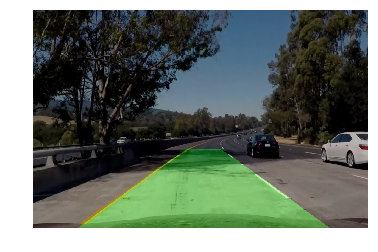

In [12]:
# List of processed images
final_imgs = []

# For each test image
for processed_imgs, img in enumerate(undist_test_imgs):
    # Black canvas image-like to draw the lane on it
    lane_mask = np.zeros_like(img)
    
    # Sample the left lane line polynomial
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit_list[processed_imgs][0]*ploty**2 + left_fit_list[processed_imgs][1]*ploty + left_fit_list[processed_imgs][2]

    # Sample the right poly
    right_fitx = right_fit_list[processed_imgs][0]*ploty**2 + right_fit_list[processed_imgs][1]*ploty + right_fit_list[processed_imgs][2]

    # Create list with all the points
    left_samples = np.swapaxes(np.array([left_fitx, ploty]), 0, 1)
    right_samples = np.swapaxes(np.array([right_fitx, ploty]), 0, 1)
    right_samples_inv = np.flip(right_samples, 0) # Flip to draw the points in the correct order 
    vertices = np.concatenate((left_samples, right_samples_inv))
    vertices = np.array([vertices], dtype=np.int32)
    
    # Create a green polygon into the black canvas
    cv2.fillPoly(lane_mask, vertices, (0, 255, 0))
    
    # Apply inverse transformation to black canvas to unwarp the polygon
    lane_mask = cv2.warpPerspective(lane_mask, M_inv, (img.shape[1], img.shape[0]))
    
    # Add transformed mask to original image (with some transparency)
    trans = 0.7
    img = cv2.addWeighted(img, trans, lane_mask, 1-trans, 0)
    
    # Append to the list of result images
    final_imgs.append(img)
    

# Divide plot and show a sample result
original = undist_test_imgs[n_test_imgs-2]
processed = final_imgs[n_test_imgs-2]

plt.imshow(processed, aspect='auto')
plt.axis('off')

## Build an output frame to save and show it
---

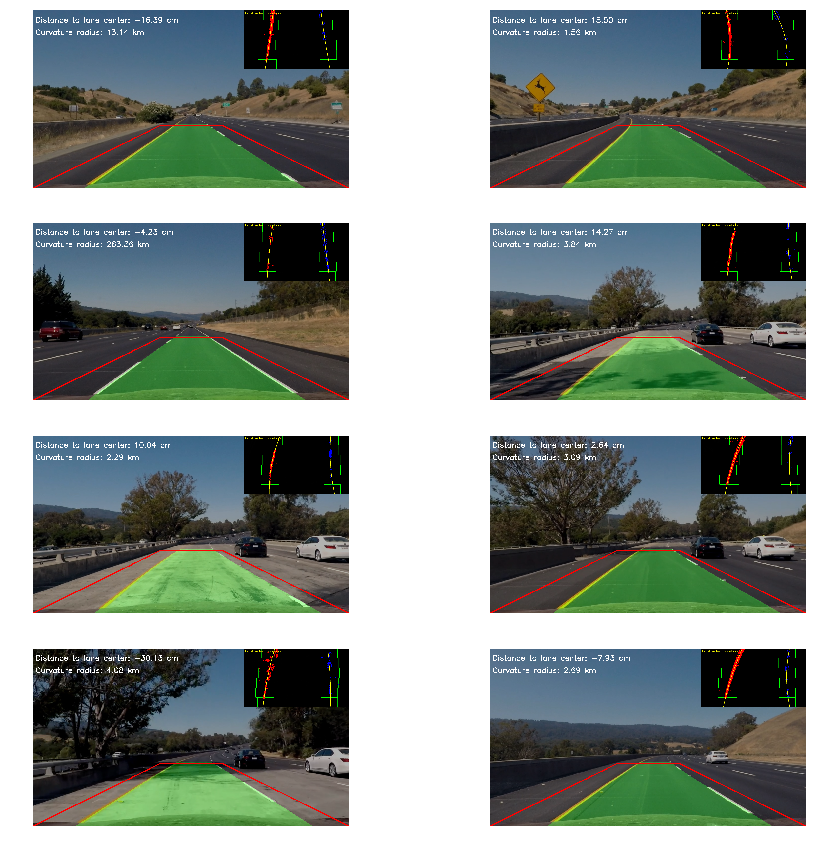

In [13]:
# List for composed final images
composed_imgs = []

# For each of the processed images
for idx, img in enumerate(final_imgs):
    ## Get image dimensions
    ysize = img.shape[0]
    xsize = img.shape[1]
    ysize2 = ysize//3
    xsize2 = xsize//3
    
    ## Add text
    # Prepare text to write (use 2 decimal precision)
    mean_rad = (left_rads[idx] + right_rads[idx])/2
    position_txt = 'Distance to lane center: ' + str("%.2f" % (rel_pos_list[idx]*100)) + ' cm'
    radius_txt = 'Curvature radius: ' + str("%.2f" % (mean_rad/1000)) + ' km'
    
    # Write text on top of the image (white)
    cv2.putText(img, position_txt, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(img, radius_txt, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    ## Add titles to secondary view (yellow)
    cv2.putText(poly_imgs[idx], 'Top-down transformed view', (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 2)
    
    ## Add RoI to image (red)
    roi_1 = (0, ysize)
    roi_2 = (int(0.4*xsize), int(0.65*ysize))
    roi_3 = (int(0.6*xsize), int(0.65*ysize))
    roi_4 = (xsize, ysize)
    
    cv2.line(img, roi_1, roi_2, (255,0,0), thickness=4)
    cv2.line(img, roi_2, roi_3, (255,0,0), thickness=4)
    cv2.line(img, roi_3, roi_4, (255,0,0), thickness=4)
    cv2.line(img, roi_4, roi_1, (255,0,0), thickness=4)
    
    ## Add warped RoI to polynomial image
    dst_1 = (100, ysize-100)
    dst_2 = (100, 100)
    dst_3 = (xsize-100, 100)
    dst_4 = (xsize-100, ysize-100)
    
    cv2.line(poly_imgs[idx], dst_1, dst_2, (255,0,0), thickness=4)
    cv2.line(poly_imgs[idx], dst_2, dst_3, (255,0,0), thickness=4)
    cv2.line(poly_imgs[idx], dst_3, dst_4, (255,0,0), thickness=4)
    cv2.line(poly_imgs[idx], dst_4, dst_1, (255,0,0), thickness=4)
    
    ## Rescale secondary views
    top_down_view = cv2.resize(poly_imgs[idx], (xsize2, ysize2))
    
    ## Build final image
    img[:ysize2, (2*xsize2+2):, :] = top_down_view

    # Append to the list of result images
    composed_imgs.append(img)
    
    # Save in output directory
    output_name = "output_images/output_0" + str(idx) + ".jpg"
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_name, img)


# Set the list of images to plot
# undist_test_imgs, binary_imgs/binary_imgs_bw, warped_imgs, poly_imgs, final_imgs, composed_imgs
image_list = composed_imgs

# Set up plot (two columns)
fig = plt.figure(figsize=(15, 15))
x_dim = 2
y_dim = len(image_list)//x_dim

# Iterate trough subplots
for idx_y in range(y_dim):
    for idx_x in range(x_dim):
        #Plot color image with solution in red
        plotted_imgs = x_dim*idx_y+idx_x #Amount of plotted images
        a = fig.add_subplot(y_dim, x_dim, plotted_imgs+1)
        plt.imshow(image_list[plotted_imgs], cmap='gray')
        plt.axis('off')

